python3 SpikeCounter/cluster/run_preprocess_stim_jobs2.py /n/holyscratch01/cohen_lab/bjia/20210921_25x_gcamp_focus/ None --remove_from_start 0 --remove_from_end 0 --n_pcs=40 --scale_factor=4 --skewness_threshold 0 --denoise 0 --pb_correct_method localmin --decorrelate 0 --start_from_downsampled 1 > jobs.txt

In [2]:
import sys
sys.path.append("../SpikeCounter")
import matplotlib as mpl
import numpy as np
import skimage.io as skio
import scipy.ndimage as ndi
import scipy.signal as signal
import scipy.stats as stats
import scipy.fft as fft
import skimage.morphology as morphology
import matplotlib.pyplot as plt
from tifffile import imsave
import scipy.ndimage as ndimage
import matplotlib.colors as colors
import matplotlib.patches as patches
import colorcet as cc
from cycler import cycler
import os
from scipy import interpolate, optimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage import filters, transform, morphology, registration
import time
import mat73
import pandas as pd
import parse
import importlib
import pickle

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils

plt.style.use("../bio_pubs_presentation.mplstyle")
ss = StandardScaler()

In [3]:
def reload_libraries():
    importlib.reload(traces)
    importlib.reload(images)
    importlib.reload(visualize)
    importlib.reload(utils)

In [4]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20210923_25x_gcamp_focus/"
figdir = "/n/cohen_lab/Lab/Papers/First Heartbeat/Figures/v8"

In [5]:
subfolder = "corrected"
expt_info = utils.process_experiment_metadata(pd.read_csv(os.path.join(rootdir,"analysis", subfolder, "experiment_data.csv")),\
                                             regexp_dict={"embryo": r"(?<=E)\d+", 
                                                          "condition": r"[A-Z,a-z]+(?=_E\d)"})
expt_info = expt_info[expt_info["condition"].isnull()]
if "level_0" in expt_info:
    del(expt_info["level_0"])

In [ ]:
um_per_px = 0.265*4

In [ ]:
def plot_wave_analysis(amplitude, Tsmoothed, Tsmoothed_dv, divergence, v, title):
    fig1, axes = plt.subplots(2,3, figsize=(14,8))
    plt.axis('off')
    axes = axes.ravel()
    fig1.suptitle(title)
    axes[0].set_title("SNR")
    i0 = axes[0].imshow(amplitude)
    plt.colorbar(i0, ax=axes[0], label= r"SNR (dB)")



    axes[1].set_title("Smoothed Activation Map")
    i1 = axes[1].imshow(Tsmoothed)
    axes[1].plot(rd[2], rd[3],"kx")
    axes[1].plot(rd[4], rd[5], "wx")
    plt.colorbar(i1, ax=axes[1], label = r"$T_{1/2} (\mathrm{ms})$")

    axes[2].set_title("Smoothed Activation Map (dV/dt)")
    i2 = axes[2].imshow(Tsmoothed_dv)
    plt.colorbar(i2, ax=axes[2], label = r"$T_{1/2} (\mathrm{ms})$")



    axes[3].set_title("Wave Direction")

    stride = 8
    X, Y = np.meshgrid(np.arange(divergence.shape[0]), np.arange(divergence.shape[1]))
    abs_vel = np.linalg.norm(v, axis=0)
    axes[3].quiver(X[::stride,::stride],Y[::stride,::stride], (v[1]/abs_vel)[::stride,::stride],\
                   (v[0]/abs_vel)[::stride,::stride], angles="xy")
    i3 = axes[3].imshow(divergence, \
                        vmin = np.percentile(divergence[~np.isnan(divergence)], 0), \
                        vmax = np.percentile(divergence[~np.isnan(divergence)], 100))
    axes[3].plot(rd[4], rd[5], "rx")
    plt.colorbar(i3, ax=axes[3], label = r"$\nabla \cdot v/|v|$")


    vx_filt = np.copy(v[0])
    vx_filt[np.abs(vx_filt)>np.percentile(np.abs(vx_filt[~np.isnan(vx_filt)]),95)] = np.nan
    vy_filt = np.copy(v[1])
    vy_filt[np.abs(vy_filt)>np.percentile(np.abs(vy_filt[~np.isnan(vy_filt)]),95)] = np.nan
    abs_vel_filt = (vx_filt**2 + vy_filt**2)**0.5

    axes[4].set_title("Wave Speed")
    i4 = axes[4].imshow(abs_vel_filt)
    plt.colorbar(i4, ax=axes[4], label = r"$|v| \mathrm{(\mu m/s)}$")
    plt.axis('on')

    axes[5].set_title("Wave Speed histogram")
    axes[5].hist(abs_vel_filt.ravel(), bins=50, density=True)
    ymin, ymax = axes[5].get_ylim()
    axes[5].text(rd[0], ymax*0.8, "mean = %d" % rd[0])
    axes[5].text(rd[1], ymax*0.9, "median = %d" % rd[1], color="red")
    axes[5].vlines(rd[0], ymin, ymax*0.8, color="black")
    axes[5].vlines(rd[1], ymin, ymax*0.9, color="red")
    axes[5].set_xlabel(r"$|v| \mathrm{(\mu m/s)}$")
    axes[5].set_ylabel("PDF")
    axes[5].get_yaxis().set_visible(False)

    axes[4].set_axis_off()
    axes[3].set_axis_off()
    axes[2].set_axis_off()
    axes[1].set_axis_off()

    plt.tight_layout()

In [ ]:
indices = np.arange(expt_info.shape[0])

In [ ]:
reload_libraries()

In [ ]:
plt.close("all")
data = []
mint = []
maxdiv = []
erred_files = {}
smoothed_ts = {}
smoothed_ts_dv = {}
amplitudes = {}
divergences = {}
velocities = {}
for i in indices:
    filename = expt_info.iloc[i]["file_name"]
    snapt = "%s_snapt.npz" % filename
    if snapt in os.listdir(os.path.join(rootdir, "analysis", subfolder)) and "fast" in filename:
        matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
        ddict, t = utils.traces_to_dict(matdata)
        dt = np.mean(np.diff(t))
        
        beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]

        try:
            amplitude = (np.abs(beta[2] - 1)/beta[5])**2 #SNR
            db = 20*np.log10(amplitude)
            db[db < 0] = np.nan
            q = images.analyze_wave_dynamics(beta, dt, um_per_px, deltax=13)
            if q is None:
                continue
            else:
                rd, Tsmoothed, Tsmoothed_dv, divergence, v = q
            rowdata = tuple(expt_info.iloc[i]) + rd
            data.append(rowdata)
            print(rowdata)
        except Exception as e:
            print(e)
            erred_files[filename] = e
            continue
        
        smoothed_ts[filename] = Tsmoothed_dv
        amplitudes[filename] = beta[2]
        divergences[filename] = divergence
        velocities[filename] = v
        plot_wave_analysis(db, Tsmoothed, Tsmoothed_dv,\
                           divergence, v, "%d, %s" % (i, expt_info.iloc[i]["file_name"]))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, filename, "waveplots.tif"))
        
data = pd.DataFrame(data, columns = expt_info.columns.tolist() + ['mean_speed', 'median_speed', 'loi_x',\
                                                                  'loi_y', 'loi_x_dv', 'loi_y_dv'])
#         break

In [ ]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)

In [ ]:
with open(os.path.join(rootdir, "analysis", subfolder, "erred_files.pickle"), "wb") as f:
    pickle.dump(erred_files, f)

In [ ]:
data_by_embryo = data.set_index("embryo")

In [ ]:
wavemaps = {}
wavemaps["velocity"] = velocities
wavemaps["divergence"] = divergences
wavemaps["smoothed_ts"] = smoothed_ts
with open(os.path.join(rootdir, "analysis", subfolder, "wavemaps.pickle"), "wb") as f:
    pickle.dump(wavemaps, f)

Load processed data

In [7]:
data = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"))
data["freq"] = np.nan
data["isi_mean"] = np.nan
data["isi_std"] = np.nan
data["n_pks"] = np.nan
for i in range(data.shape[0]):
    filename = data[["file_name"]].values.ravel()[i]
    with open(os.path.join(rootdir, "analysis", subfolder, filename, "temporal_statistics.pickle"), "rb") as f:
        temp_stats = pickle.load(f)
        for k, v in temp_stats.items():
            data.at[i, k] = v

Text(0, 0.5, 'Frequency (Hz)')

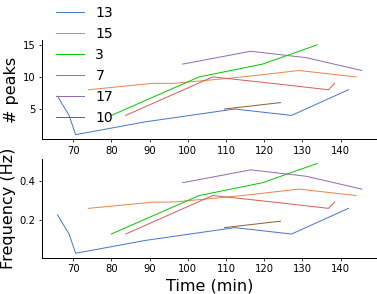

In [8]:
data_by_embryo = data.set_index("embryo")
p0=2
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    fig1, axes = plt.subplots(2,1, figsize=(6,4))
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        axes[0].plot(embryo_info["offset"]/60, embryo_info["n_pks"], label=str(embryo))   
        axes[1].plot(embryo_info["offset"]/60, embryo_info["freq"])
axes[0].legend()
axes[1].set_xlabel("Time (min)")
axes[0].set_ylabel("# peaks")
axes[1].set_ylabel("Frequency (Hz)")

In [ ]:
import pickle
with open(os.path.join(rootdir, "analysis", subfolder, "wavemaps.pickle"), "rb") as f:
    wavemaps = pickle.load(f)
velocities = wavemaps["velocity"]
divergences = wavemaps["divergence"]
smoothed_ts = wavemaps["smoothed_ts"]

In [ ]:
p0=2
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[embryo]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        for i in range(embryo_info.shape[0]):
            filename = embryo_info.iloc[i]["file_name"]
            matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
            ddict, t = utils.traces_to_dict(matdata)
            dt = np.mean(np.diff(t))
            
            Tsmoothed_dv = smoothed_ts[filename]
            fv = Tsmoothed_dv[np.isfinite(Tsmoothed_dv)]
            Tsmoothed_apod = Tsmoothed_dv - np.percentile(fv, p0)
            axes[i].imshow(Tsmoothed_apod, vmin=0, vmax=450)
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title(embryo_info.iloc[i]["start_time"], fontsize=12)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_wavemap_montage.tif" % str(embryo)))

In [ ]:
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes = np.array([axes]).ravel()
        for i in range(embryo_info.shape[0]):
            filename = embryo_info[["file_name"]].values.ravel()[i]
            img, _ = images.load_image(rootdir, filename, subfolder="downsampled")
            mean_img = np.mean(img, axis=0)
            skio.imsave(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"), mean_img)
            axes[i].imshow(mean_img)
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_mean_img_montage.tif" % str(embryo)))

In [ ]:
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes = np.array([axes]).ravel()
        fig2, axes2 = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes2 = np.array([axes2]).ravel()
        corrected_images = []
        embryo_shifts = [[0,0]]
        
        for i in range(embryo_info.shape[0]):
            filename = embryo_info[["file_name"]].values.ravel()[i]
            img, _ = images.load_image(rootdir, filename, subfolder="downsampled")
            mean_img = np.mean(img, axis=0)
            skio.imsave(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"), mean_img)
#             mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"))
            axes[i].imshow(mean_img)
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
            if i > 0:
                shift, _, _ = registration.phase_cross_correlation(corrected_images[-1], mean_img)
#                 print(shift)
                v, u = shift
                embryo_shifts.append(shift)
                nr, nc = mean_img.shape
                row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
                corrected_img = transform.warp(mean_img, np.array([row_coords-v, col_coords-u]), mode="edge")
#                 shift2 = registration.phase_cross_correlation(corrected_images[-1], corrected_img)
#                 v, u = shift
#                 corrected_img = transform.warp(corrected_img, np.array([row_coords-v, col_coords-u]), mode="edge")
            else:
                corrected_img = mean_img
            axes2[i].imshow(corrected_img)
            axes2[i].invert_yaxis()
            axes2[i].set_axis_off()
            axes2[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
            corrected_images.append(corrected_img)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
        fig2.text(0.2, 0.1, "E%s corrected" % str(embryo))
        embryo_shifts = np.array(embryo_shifts)
        np.savez(os.path.join(rootdir, "analysis", subfolder,\
                              "E%s_registration_shifts.npz" % str(embryo)), embryo_shifts=embryo_shifts)
#         plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_mean_img_montage.tif" % str(embryo)))

In [ ]:
data_by_embryo = data.set_index("embryo")
p0=2
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes = np.array([axes]).ravel()
        shifts = np.load(os.path.join(rootdir, "analysis", subfolder,\
                                      "E%s_registration_shifts.npz"% str(embryo)))["embryo_shifts"]
        print(embryo_info.shape)
        for i in range(embryo_info.shape[0]):
            v,u = shifts[i]
            filename = embryo_info[["file_name"]].values.ravel()[i]
            
            matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
            ddict, t = utils.traces_to_dict(matdata)
            dt = np.mean(np.diff(t))
            
            Tsmoothed_dv = smoothed_ts[filename]
            fv = Tsmoothed_dv[np.isfinite(Tsmoothed_dv)]
            Tsmoothed_apod = Tsmoothed_dv - np.percentile(fv, p0)
            
            nr, nc = Tsmoothed_apod.shape
            row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
            Tsmoothed_apod = transform.warp(Tsmoothed_apod, np.array([row_coords-v, col_coords-u]),\
                                            mode="constant", cval=np.nan)
            
            axes[i].imshow(Tsmoothed_apod)
            loi_x = embryo_info[["loi_x_dv"]].values.ravel()[i]
            loi_y = embryo_info[["loi_y_dv"]].values.ravel()[i]
            axes[i].plot(loi_x + u, loi_y + v, "kx")
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_wavemap_montage_registered.tif" % str(embryo)))

(7, 14)
(6, 14)
(4, 14)
(5, 14)
(4, 14)
(2, 14)


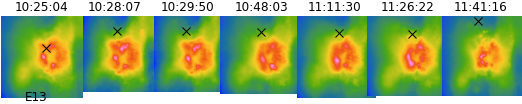

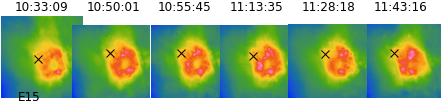

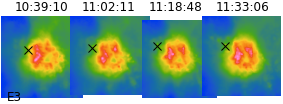

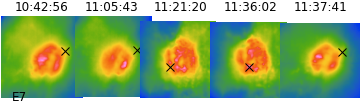

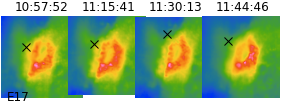

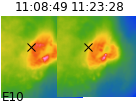

In [10]:
data_by_embryo = data.set_index("embryo")
p0=2
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes = np.array([axes]).ravel()
        shifts = np.load(os.path.join(rootdir, "analysis", subfolder,\
                                      "E%s_registration_shifts.npz"% str(embryo)))["embryo_shifts"]
        print(embryo_info.shape)
        for i in range(embryo_info.shape[0]):
            v,u = shifts[i]
            filename = embryo_info[["file_name"]].values.ravel()[i]
            mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"))
            nr, nc = mean_img.shape
            row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
            mean_img = transform.warp(mean_img, np.array([row_coords-v, col_coords-u]),\
                                            mode="constant", cval=np.nan)
            
            axes[i].imshow(mean_img)
            loi_x = embryo_info[["loi_x_dv"]].values.ravel()[i]
            loi_y = embryo_info[["loi_y_dv"]].values.ravel()[i]
            axes[i].plot(loi_x + u, loi_y + v, "kx")
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_loi_on_structure.tif" % str(embryo)))

In [ ]:
data_by_embryo = data.set_index("embryo")
p0=2
p1 = 98
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in ["15"]:
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes = np.array([axes]).ravel()
        shifts = np.load(os.path.join(rootdir, "analysis", subfolder,\
                                      "E%s_registration_shifts.npz"% str(embryo)))["embryo_shifts"]
        print(embryo_info.shape)
        for i in range(embryo_info.shape[0]):
            v,u = shifts[i]
            filename = embryo_info[["file_name"]].values.ravel()[i]
            
            matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
            ddict, t = utils.traces_to_dict(matdata)
            dt = np.mean(np.diff(t))
            
            Tsmoothed_dv = smoothed_ts[filename]
            fv = Tsmoothed_dv[np.isfinite(Tsmoothed_dv)]
            b1, b2 = np.percentile(fv, [p0,p1])
            Tsmoothed_apod = (Tsmoothed_dv - b1)/(b2-b1)
            
            nr, nc = Tsmoothed_apod.shape
            row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
            Tsmoothed_apod = transform.warp(Tsmoothed_apod, np.array([row_coords-v, col_coords-u]),\
                                            mode="constant", cval=np.nan)
            q = axes[i].imshow(Tsmoothed_apod, vmin=0, vmax=1, cmap="cet_CET_R1_r")
            loi_x = embryo_info[["loi_x_dv"]].values.ravel()[i]
            loi_y = embryo_info[["loi_y_dv"]].values.ravel()[i]
            axes[i].plot(loi_x + u, loi_y + v, "kx")
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].text(0.35, 0.1, "%.1f'" % ((embryo_info[["offset"]].values.ravel()[i]-\
                                        embryo_info[["offset"]].values.ravel()[0])/60), fontsize=12, \
                         transform=axes[i].transAxes)
        cax = plt.axes([0.6, 0.92, 0.2, 0.05])
        cbar = plt.colorbar(q, cax=cax, orientation="horizontal")
        cax.set_xlabel("Rel. activation time", size=9)
        cax.xaxis.set_label_coords(0.5, 3)
        cbar.set_ticks([0,0.25,0.5,0.75,1])
#         fig1.text(0.2, 0.1, "E%s" % str(embryo))
        plt.savefig(os.path.join(figdir, "Figure4", "POSTER_loi_fixed.tif"), dpi=600)
#         plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_wavemap_montage_registered.tif" % str(embryo)))

In [ ]:
with plt.style.context("../bio_publications.mplstyle"):
    fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
    axes = axes.ravel()
    for i in range(embryo_info.shape[0]):
        filename = embryo_info.iloc[i]["file_name"]
        matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
        ddict, t = utils.traces_to_dict(matdata)
        dt = np.mean(np.diff(t))

        try:
            amplitude = beta[2]
            amplitude = amplitude[~np.isnan(amplitude)]
            threshold = min(np.percentile(amplitude, 45), 1.01)
            v = velocities[filename]
            abs_vel = np.linalg.norm(v, axis=0)
            Tsmoothed_dv = smoothed_ts[filename]
            fv = Tsmoothed_dv[np.isfinite(Tsmoothed_dv)]
            Tsmoothed_apod = Tsmoothed_dv - np.percentile(fv, p0)

            stride = 14

            q = axes[i].imshow(Tsmoothed_apod, vmin=0, vmax=450)
            X, Y = np.meshgrid(np.arange(Tsmoothed_dv.shape[0]), np.arange(Tsmoothed_dv.shape[1]))
#             axes[i].quiver(X[::stride,::stride],Y[::stride,::stride], (v[1]/abs_vel)[::stride,::stride],\
#                            (v[0]/abs_vel)[::stride,::stride], angles="xy", scale=20)
#             axes[i].invert_yaxis()
#             axes[i].set_axis_off()
        except Exception as e:
            print(e)
            erred_files[filename] = e
            continue
#     plt.tight_layout()
    cax = plt.axes([0.6, 0.92, 0.2, 0.05])
    cbar = plt.colorbar(q, cax=cax, orientation="horizontal")
    cax.set_xlabel("Activation Time (ms)", size=9)
    cax.xaxis.set_label_coords(0.5, 3)
    cbar.set_ticks([0,100,200,300,400])
plt.savefig(os.path.join(figdir, "Figure4", "E8_loi.tif"), dpi=300)

In [ ]:
embryo = 1
embryo_info = expt_info_by_embryo.loc[str(embryo)].iloc[5:9]
p0 = 1
p1 = 99
finite_values = np.array([])
for i in range(embryo_info.shape[0]):
    Tsmoothed_dv = smoothed_ts[filename]
    fv = Tsmoothed_dv[np.isfinite(Tsmoothed_dv)]
    Tsmoothed_apod = np.maximum(Tsmoothed_dv - np.percentile(fv, p0), 0)
    finite_values = np.append(finite_values, Tsmoothed_apod[np.isfinite(Tsmoothed_apod)])
max_value = np.percentile(finite_values, p1)

In [ ]:
with plt.style.context("../bio_publications.mplstyle"):
    fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
    axes = axes.ravel()
    for i in range(embryo_info.shape[0]):
        filename = embryo_info.iloc[i]["file_name"]
        matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
        ddict, t = utils.traces_to_dict(matdata)
        dt = np.mean(np.diff(t))

        try:
            amplitude = beta[2]
            amplitude = amplitude[~np.isnan(amplitude)]
            threshold = min(np.percentile(amplitude, 45), 1.01)
            v = velocities[filename]
            abs_vel = np.linalg.norm(v, axis=0)
            Tsmoothed_dv = smoothed_ts[filename]
            fv = Tsmoothed_dv[np.isfinite(Tsmoothed_dv)]
            Tsmoothed_apod = Tsmoothed_dv - np.percentile(fv, p0)

            stride = 14

            q = axes[i].imshow(Tsmoothed_apod, vmin=0, vmax=450)
            X, Y = np.meshgrid(np.arange(Tsmoothed_dv.shape[0]), np.arange(Tsmoothed_dv.shape[1]))
            axes[i].quiver(X[::stride,::stride],Y[::stride,::stride], (v[1]/abs_vel)[::stride,::stride],\
                           (v[0]/abs_vel)[::stride,::stride], angles="xy", scale=20)
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
        except Exception as e:
            print(e)
            erred_files[filename] = e
            continue
#     plt.tight_layout()
visualize.plot_img_scalebar(fig1, axes[0], 25, 40, 50, 8, pix_per_um = 1/um_per_px, fontsize=9, \
                  color="black", unit="\mu m", yax_direction="up", text_pos="below", scale=0.7,
                 show_label=True)
plt.savefig(os.path.join(figdir, "Figure4", "E1_loi.tif"), dpi=300)

### Manual edits

In [ ]:
def mask15(Ts, divergence):
    nan_mask = morphology.binary_dilation(np.pad(np.isnan(Ts),1, constant_values=True), \
                                        footprint=morphology.disk(5))
    
    return np.ma.masked_array(Ts, nan_mask[1:-1,1:-1] |\
                                      (divergence < 0.5))
def mask24(Ts, divergence):
    nan_mask = morphology.binary_dilation(np.pad(np.isnan(Ts),1, constant_values=True), \
                                        footprint=morphology.disk(5))
    
    return np.ma.masked_array(Ts, nan_mask[1:-1,1:-1] |\
                                      (divergence < 0.5))

In [ ]:
data = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"))

In [ ]:
data.drop(labels=[0]).to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"))

In [ ]:
data = data.drop(labels=[0])

In [ ]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)

In [ ]:
i = 24

filename = expt_info.iloc[i]["file_name"]
snapt = "%s_snapt.npz" % filename
if snapt in os.listdir(os.path.join(rootdir, "analysis", subfolder)) and "fast" in filename:
    matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
    ddict, t = utils.traces_to_dict(matdata)
    dt = np.mean(np.diff(t))

    beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]

    try:
        amplitude = beta[2]
        amplitude = amplitude[~np.isnan(amplitude)]
        threshold = min(np.percentile(amplitude, 45), 1.01)
        q = analyze_wave_dynamics(beta, dt, um_per_px, threshold, mask_function_tsmoothed=mask24)
        if q is None:
            raise
        else:
            rd, Tsmoothed, Tsmoothed_dv, divergence, v = q
            rowdata = tuple(expt_info.iloc[i]) + rd
            print(rowdata)
    except Exception as e:
        erred_files[filename] = e

    smoothed_ts[filename] = Tsmoothed_dv
    amplitudes[filename] = beta[2]
    divergences[filename] = divergence
    plot_wave_analysis(beta[2], Tsmoothed, Tsmoothed_dv,\
                       divergence, v, "%d, %s" % (i, expt_info.iloc[i]["file_name"]))

In [ ]:
data.at[data["file_name"]==filename] = rowdata

In [ ]:
%matplotlib inline
files = data["file_name"].to_list()
fig1, axes = visualize.tile_plots_conditions(files, (4,4))
axes = axes.ravel()
mean_imgs = {}
amplitudes = {}
for idx, f in enumerate(files):
    img = skio.imread(os.path.join(rootdir, "downsampled", "%s.tif" % f))
    mean_img = img.mean(axis=0)
    mean_imgs[f] = mean_img
    axes[idx].imshow(mean_img)
    axes[idx].set_axis_off()
    snapt = "%s_snapt.npz" % f
    beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]
    amplitudes[f] = beta[2]
plt.tight_layout()
plt.savefig(os.path.join(rootdir, "analysis", subfolder, "mean_images.tif"), dpi=300)

In [ ]:
# data.at[7,["mean_speed", "median_speed", "loi_x", "loi_y"]] = [mean, median,\
#                                               min_activation_time[1], min_activation_time[0]]

In [ ]:
data = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"))

In [ ]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)

In [ ]:
data[["ref1_x", "ref1_y", "ref2_x", "ref2_y"]] = np.nan

### Calculate reference points for hearts

In [ ]:
data.shape[0]

In [ ]:
%matplotlib notebook
i = 26
fname = data["file_name"].iloc[i]
print(fname)
snapt = "%s_snapt.npz" % fname
beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]
amplitude = beta[2]
h = HyperStackViewer(amplitude, width=6, height=6)
h.select_points_clicky(2)

In [ ]:
data.at[i,["ref1_x", "ref1_y", "ref2_x", "ref2_y"]] = [h.points[0][0], h.points[0][1], h.points[1][0], h.points[1][1]]

In [ ]:
data["experiment"] = "20210923_25x_gcamp_focus"
data[["imheight", "imwidth"]] = amplitude.shape

In [ ]:
data.at[23, "embryo"] = 8
data.at[17, "embryo"] = 8

In [ ]:
data

In [ ]:
sorted_by_embryo = data.set_index("embryo").sort_index()

In [ ]:
edata

In [ ]:
axis_length = ((data["ref1_x"] - data["ref2_x"])**2 + (data["ref1_y"] - data["ref2_y"])**2)**0.5

In [ ]:
plt.hist(axis_length)

In [ ]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)

### Check reference axis labeling

In [ ]:
!ls {os.path.join(rootdir, "Snaps")}

In [ ]:
data_by_embryo = data.set_index("embryo")
data_by_embryo.index.unique()

In [ ]:
embryo = 13
edata = data_by_embryo.loc[embryo]

In [ ]:
files = list(edata["file_name"])
fig1, axes = visualize.tile_plots_conditions(files, (5,5))
for i in range(edata.shape[0]):
    axes[i].imshow(mean_imgs[files[i]], cmap="gray")
    cs = axes[i].contour(amplitudes[files[i]], alpha=0.5, levels=5)
    plt.colorbar(cs, ax=axes[i])
    x1, y1, x2, y2 = edata.iloc[i][["ref1_x", "ref1_y", "ref2_x", "ref2_y"]]
    axes[i].plot([x1,x2], [y1,y2])

In [ ]:
files = list(edata["file_name"])
fig1, axes = visualize.tile_plots_conditions(files, (5,5))
for i in range(edata.shape[0]):
    axes[i].imshow(mean_imgs[files[i]], cmap="gray")
    cs = axes[i].contour(smoothed_ts[files[i]], alpha=0.5, levels=10)
    plt.colorbar(cs, ax=axes[i])
    x1, y1, x2, y2 = edata.iloc[i][["ref1_x", "ref1_y", "ref2_x", "ref2_y"]]
    axes[i].plot([x1,x2], [y1,y2])

In [ ]:
%matplotlib notebook
i = 1
fname = files[i]
print(fname)
# snapt = "%s_snapt.npz" % fname
# beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]
# amplitude = beta[2]
h = HyperStackViewer(mean_imgs[fname], width=6, height=6)
h.select_points_clicky(2)

In [ ]:
full_table_loc = data.loc[data["file_name"]==fname].index[0]
data.at[full_table_loc,["ref1_x", "ref1_y", "ref2_x", "ref2_y"]] = [h.points[0][0], h.points[0][1], h.points[1][0], h.points[1][1]]

In [ ]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)